# Generate a Hex map for the species in the database

The code is based on the example provided by Matilda Stevenson et al. at:
https://labs.ala.org.au/posts/2021-04-14_hex-maps-for-species-occurrence-data/post.html

Load packages

In [2]:
library(ggplot2)
library(tidyr)
library(dplyr)
library(ozmaps)
library(sf)
library(purrr)
library(galah)

Linking to GEOS 3.10.1, GDAL 3.4.2, PROJ 9.0.0; sf_use_s2() is TRUE


Attaching package: ‘galah’


The following object is masked from ‘package:stats’:

    filter




In [3]:
here::i_am("R/Map-species-in-hexgrid.ipynb")

here() starts at /home/jferrer/proyectos/fireveg/fireveg-analysis



Read the email of the galah user for galah config

In [6]:
galah_config(email = readLines("../secrets/galah-email.txt"))

## Read spatial data for NSW

In [7]:
nsw <- st_transform(ozmaps::ozmap_states, 4326) %>% filter(NAME == "New South Wales")

Make grid and select which intersect NSW map

In [8]:
grid_all <- st_make_grid(nsw, 
                         cellsize = 0.5, 
                         what = "polygons", 
                         square = FALSE,
                         flat_topped = TRUE)

keep_hexes <- st_intersects(grid_all, nsw) %>%
  as.data.frame(.) %>%
  pull(row.id)

oz_grid <- grid_all[keep_hexes]

## List of species from the database

In [9]:
litrev_species <- readRDS(here::here("data","Summary-traits-species.rds"))

In [10]:
glimpse(litrev_species)

Rows: 15,732
Columns: 18
$ family   <chr> "Brassicaceae", "Myrtaceae", "Myrtaceae", "Apiaceae", "Apiace…
$ genus    <chr> "Lepidium", "Eucalyptus", "Melaleuca", "Actinotus", "Apium", …
$ spp      <dbl> 2358, 2359, 2360, 2361, 2362, 2363, 2364, 2365, 2366, 2367, 2…
$ species  <chr> "Lepidium oxytrichum", "Eucalyptus williamsiana", "Melaleuca …
$ nquadrat <dbl> 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 15, 0, 0, 0, 0, 0, 0, 8, 0, 0, …
$ germ8    <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0…
$ rect2    <dbl> 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0…
$ germ1    <dbl> 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0…
$ grow1    <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0…
$ repr4    <dbl> 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ surv5    <dbl> 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 2, 0…
$ surv6    <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ surv7    <dbl

## ALA Occurrence records from one species

In [9]:
(qry_spp <- litrev_species %>% slice(2) %>% pull(species))

[1] "Eucalyptus williamsiana"

In [10]:
target_occ <- galah_call() %>%
    galah_identify(qry_spp) %>%
    galah_apply_profile(ALA) %>%
    galah_geolocate(nsw, type = "bbox") %>%
    atlas_occurrences()

Data returned for bounding box:
xmin = 140.99927 xmax = 153.62987 ymin = -37.50502 ymax = -28.15702
This query will return 287 records



Checking queue
Current queue size: 1 inqueue . running 

In [12]:
target_occ %>% slice_head()

decimalLatitude,decimalLongitude,eventDate,scientificName,taxonConceptID,recordID,dataResourceName,occurrenceStatus
<dbl>,<dbl>,<dttm>,<chr>,<chr>,<chr>,<chr>,<chr>
-35.41719,149.2475,NA,Eucalyptus williamsiana,https://id.biodiversity.org.au/node/apni/2891756,a16007ef-df95-47a3-9750-606927355c8f,NSW AVH feed,PRESENT


In [14]:
target_points_sf <- target_occ %>% 
  st_as_sf(coords = c("decimalLongitude", "decimalLatitude"), 
  crs = st_crs(4326))

In [15]:
intersect <- st_intersects(target_points_sf, oz_grid)
counts <- as_tibble(table(unlist(intersect)), 
          .name_repair = "unique") %>%
  rename("hex_id" = 1,
         "count" = 2) %>%
  mutate(hex_id = as.integer(hex_id)) %>%
  replace_na(list(count = 0))

New names:
• `` -> `...1`


In [16]:
oz_grid <- oz_grid %>%
  as_tibble() %>%
  mutate(id = row_number()) %>%
  full_join(counts,
            by = join_by(id == hex_id)) %>%
  st_as_sf()

oz_grid |> head()

Registered S3 method overwritten by 'geojsonsf':
  method        from   
  print.geojson geojson



geometry,id,count
<POLYGON [°]>,<int>,<int>
POLYGON ((149.3709 -37.5050...,1,NA
POLYGON ((148.9378 -37.2550...,2,NA
POLYGON ((149.8039 -37.2550...,3,NA
POLYGON ((148.5048 -37.0050...,4,NA
POLYGON ((149.3709 -37.0050...,5,NA
POLYGON ((148.0718 -36.7550...,6,NA


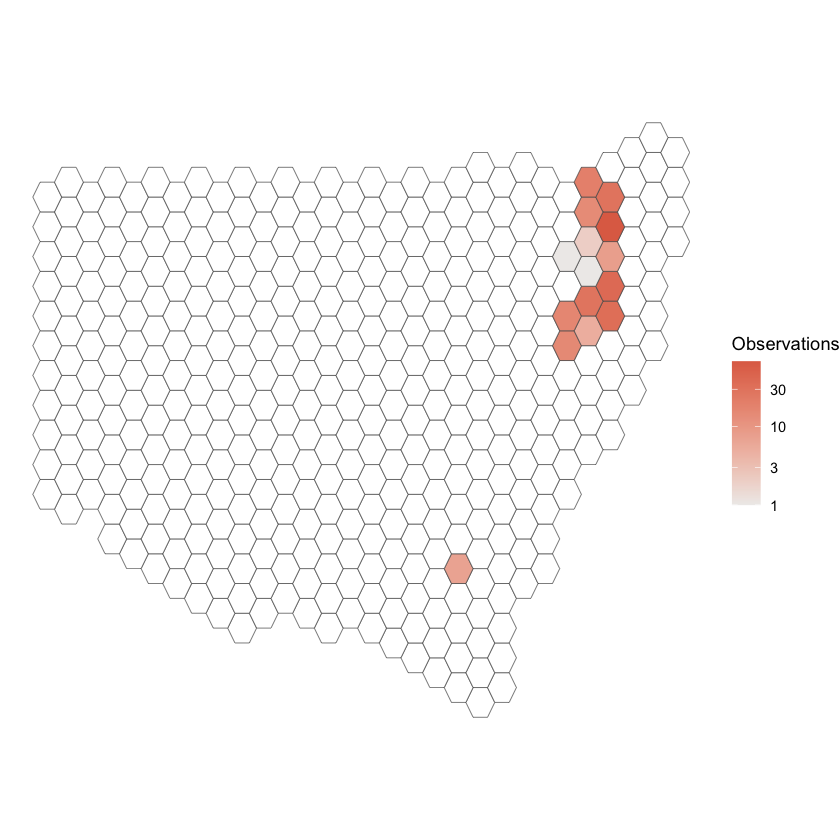

In [17]:
ggplot() +
  geom_sf(data = oz_grid, aes(fill = count), size = .01) +
  scale_fill_gradientn(colours = c("#EEECEA", "#E06E53"), 
                       na.value = "white", 
                       trans = "log10",
                       labels = scales::comma_format(),
                       n.breaks = 6,
                       guide = guide_colourbar(title = "Observations")) +
  theme_void()

In [29]:
oz_grid[1:10,]

geometry,id,count
<POLYGON [°]>,<int>,<int>
POLYGON ((149.3709 -37.5050...,1,14
POLYGON ((148.9378 -37.2550...,2,NA
POLYGON ((149.8039 -37.2550...,3,5
POLYGON ((148.5048 -37.0050...,4,NA
POLYGON ((149.3709 -37.0050...,5,9
POLYGON ((148.0718 -36.7550...,6,NA
POLYGON ((148.9378 -36.7550...,7,NA
POLYGON ((149.8039 -36.7550...,8,27
POLYGON ((147.6388 -36.5050...,9,NA


In [30]:
target_occ <- galah_call() %>%
    galah_identify("Brunoniella pumilio") %>%
    galah_apply_profile(ALA) %>%
    galah_geolocate(st_geometry(oz_grid)[1]) %>%
    atlas_occurrences()

This query will return 17 records



Checking queue
Current queue size: 2 inqueue . running .

## Number of species per grid

Now, let use species counts per grid, like this example from Dax Kellie: https://labs.ala.org.au/posts/2022-05-17_3d-map/post.html

In [18]:
get_counts <- function(hexagon,spplist="plantae"){

    wkt_string <- st_geometry(oz_grid %>% slice(hexagon))
    # get counts
    result <- galah_call() |>
      galah_geolocate(wkt_string) |>
      galah_identify(spplist) |>
      galah_filter(decimalLongitude > 110,
                   year >= 2019) |>
      galah_apply_profile(ALA) |>
      atlas_counts(type = "species", # get species counts
                   limit = NULL)
    
    # light formatting to catch errors
    if(is.null(result)){
      tibble(count = NA, id = hexagon)
    }else{
      result$id <- hexagon
      result
    }
  }

In [26]:
head(qry_spps <- litrev_species %>% slice(1:200) %>% pull(species))

[1] "Lepidium oxytrichum"     "Eucalyptus williamsiana"
[3] "Melaleuca glomerata"     "Actinotus helianthi"    
[5] "Apium prostratum"        "Cryptocarya obovata"

In [27]:
get_counts(1, spplist=qry_spps)

Warning message:
“Search returned multiple taxa due to a homonym issue.
ℹ Please provide another rank in your search to clarify taxa.
ℹ Use a `tibble` to clarify taxa, see `?search_taxa`.
✖ Homonym issue with "Isopogon nwrhidoliua".”
No taxon matches were found for "Isopogon nwrhidoliua" in the selected atlas (Australia).
Warning message:
“Unmatched taxa. Results returned for 199 of 200 taxon IDs”
Calling the API failed for `atlas_counts`.
ℹ This might mean that the API is down, or that you are not connected to the internet
ℹ Double check that your query is correct, or try again later


id
<dbl>


In [22]:

# download number of species for each polygon
counts_list <- map(seq(1,10), get_counts, spplist=qry_spps)


In [23]:

# bind lists to data frame
counts_df <- map_dfr(counts_list, rbind)


In [24]:
oz_grid %>% inner_join(counts_df,by="id")

geometry,id,count.x,count.y
<POLYGON [°]>,<int>,<int>,<int>
POLYGON ((149.3709 -37.5050...,1,NA,5
POLYGON ((148.9378 -37.2550...,2,NA,4
POLYGON ((149.8039 -37.2550...,3,NA,4
POLYGON ((148.5048 -37.0050...,4,NA,3
POLYGON ((149.3709 -37.0050...,5,NA,5
POLYGON ((148.0718 -36.7550...,6,NA,2
POLYGON ((148.9378 -36.7550...,7,NA,3
POLYGON ((149.8039 -36.7550...,8,NA,5
POLYGON ((147.6388 -36.5050...,9,NA,1


In [65]:
counts_list <- map(seq_along(oz_grid$id), get_counts)
counts_df <- map_dfr(counts_list, rbind)
oz_df <- oz_grid %>% inner_join(counts_df,by="id")

In [84]:
hex_map <- ggplot() +
  geom_sf(
    data = oz_df,
    mapping = aes(fill = log10(1+count.y)), # log10 + 1 transformed
    alpha = 1,
    color = NA) +
  scale_fill_distiller(name = "Number of species \n(since 1 Jan, 2019)",
                       type = "seq",
                       direction = 1,
                       limits = c(0,4),
                       labels = c("10", "100", "1,000"),
                       palette = "Greens",
                       # edit legend to be horizontal-bottom
                       guide = guide_colorsteps(direction = "horizontal",
                                                label.position = "top",
                                                title.position = "bottom",
                                                title.hjust = 0.5)
                       ) +
  # add map
  geom_sf(data = nsw,
          color = "black",
          fill = NA)+
  # Adjust text and make aesthetic more minimal
  theme(title = element_text(face = "bold"),
        legend.title = element_text(size = 19),
        legend.position = "bottom",
        legend.key.width = unit(28, 'mm'),
        legend.text = element_text(size = 16),
        plot.background = element_rect(fill = 'white', colour = 'white'),
        panel.background = element_rect(fill = 'white', colour = 'white'),
        axis.title = element_blank()
        )


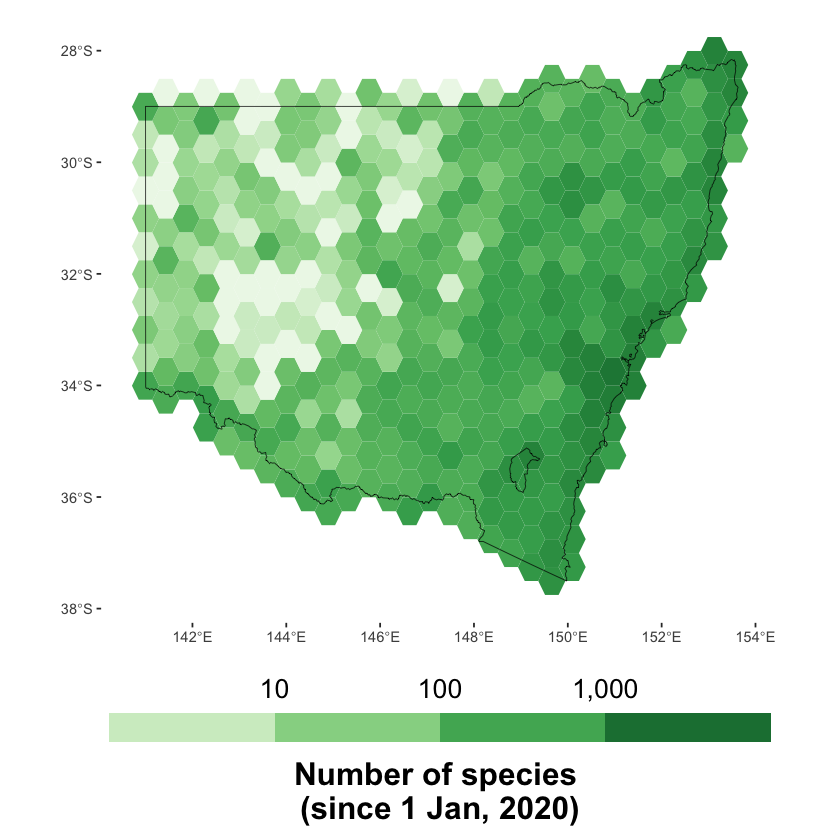

In [85]:

hex_map

In [81]:
max(log10(1+oz_df$count.y))

[1] 3.409933